(4435, 52) (2957, 52) (4435,) (2957,)
Precision: 0.02
Recall: 0.34
Accuracy: 0.77
F1 Score: 0.03
Confusion Matrix:
[[2258  667]
 [  21   11]]
Matthews Correlation Coefficient: 0.0285
Macro-averaged Precision: 0.50
Macro-averaged Recall: 0.56
Macro-averaged F1 Score: 0.45
Optimal Threshold: 0.0000
Max Metric Value: 10000.0000


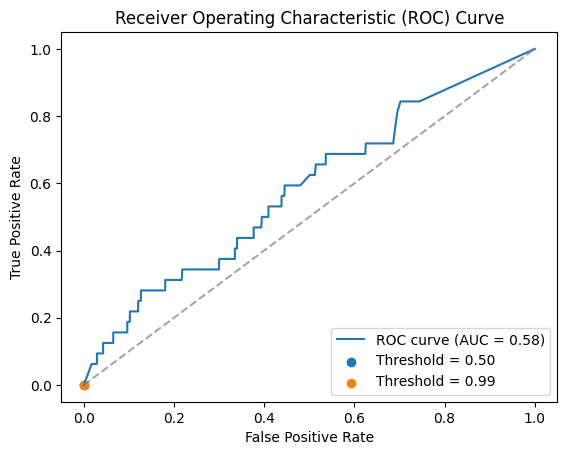

49502.0


C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\igraph\io\files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  return reader(f, *args, **kwds)


IGRAPH DN-T 7392 49502 -- 
+ attr: Active_site (v), Alternative_products (v), Betweenness (v), Binding_site (v), Catalytic_activity (v), Closeness (v), Cluster_coefficients (v), Disease (v), Disulfide_bond (v), Function (v), Indegree (v), Interaction (v), Modified_residue (v), Mutagenesis (v), Natural_variant (v), Nearest_Neighbor_Degree (v), Outdegree (v), PTM (v), Pagerank (v), STP_involvement (v), Sequence_conflict (v), Similarity (v), Subcellular_location (v), Subunit (v), Tissue_Specificity (v), Transmembrane (v), id (v), label (v), name (v), type (v)


Computing transition probabilities:   0%|          | 0/7392 [00:00<?, ?it/s]

In [1]:
import networkx as nx
from node2vec import Node2Vec
from igraph import Graph
import igraph as ig
import numpy as np
import json
import pandas as pd
from gensim.models import Word2Vec
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, log_loss, matthews_corrcoef, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_recall_fscore_support as prf_support
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from bunch_of_KNN_ import run_KNNss_100
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


node_list_path = r'C:\Users\George\Desktop\ISEF-2023\Datas\Node list\back up\current_protein_Signal+meta+targets.json'
with open(node_list_path, 'r') as file:
    node_list = json.load(file)

# Load your adjacency matrix
path = r'C:\Users\George\Desktop\ISEF-2023\Model\matrix\_PPSS.txt'
matrix = np.loadtxt(path)
print(matrix.sum())
graph = r'C:\Users\George\Desktop\ISEF-2023\Network construction\PPI_homo_graph_features_loaded.graphml'
# Create an igraph object
PPI_graph = ig.Graph.Load(graph, format='graphml')

# Set node names for igraph graph
PPI_graph.vs['name'] = node_list

print(PPI_graph.summary())

PPI_graphx = Graph.to_networkx(PPI_graph)

# Specify the parameters for node2vec
dimensions = 26 # Dimensionality of node embeddings
num_walks = 100
walk_length = 50

p=1
q=1

# Create a node2vec model
node2vec = Node2Vec(PPI_graphx, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=10, p=p,q=q)

# Fit the model to generate embeddings
model = node2vec.fit(window=10, min_count=1)

embedding_data = []
for node in model.wv.key_to_index:
    vector = model.wv.get_vector(node)
    node_name = PPI_graphx.nodes[int(node)]['name']  # Retrieve node name from the graph
    embedding_data.append([node_name] + vector.tolist())

column_names = ['node_name'] + [f'dim_{i}' for i in range(model.vector_size)]
embedding_df = pd.DataFrame(embedding_data, columns=column_names)

In [2]:
import torch
#print(embedding_df.shape)  # Output: (7393, 129)
#print(embedding_df.head())  # Output: Display the first few rows of the DataFrame

feature_keys = [
    "Indegree", "Outdegree", "Closeness", "Betweenness", "Pagerank", "Cluster_coefficients",
    "Nearest_Neighbor_Degree", "Similarity", "Subunit", "Transmembrane",
    "Catalytic_activity", "Interaction", "Tissue_Specificity", "Disease",
    "Sequence_conflict", "Modified_residue", "Function", "Binding_site",
    "Natural_variant", "Alternative_products", "Subcellular_location",
    "Active_site", "Disulfide_bond", "Mutagenesis", "PTM", "STP_involvement"
]

features = torch.tensor([
    PPI_graph.vs[key] for key in feature_keys
], dtype=torch.float).t()

# Assuming you have a label attribute in your graph
labels = torch.tensor(PPI_graph.vs["label"], dtype=torch.float)

df__ = pd.DataFrame(features.numpy())
#df__['label'] = labels.numpy()

print(df__.shape)  # Output: (7393, 129)
print(df__.head())  # Output: Display the first few rows of the DataFrame
print(embedding_df)
#df = pd.DataFrame(features.numpy())
#df['label'] = labels.numpy()

#embedding_df_final = pd.concat([embedding_df, df__], axis=1)
embedding_df_final = embedding_df
#embedding_df_final = df__

print(embedding_df_final.shape)  # Output: (7393, 129)
print(embedding_df_final.head())  # Output: Display the first few rows of the DataFrame


embedding_df_final.to_csv(r'C:\Users\George\Desktop\ISEF-2023\Model\test\node2vec_embedding_100walks.csv', index=False)

(7392, 26)
    0    1         2            3         4         5    6    7    8    9   \
0  2.0  1.0  0.263599     9.294351  0.000050  0.000000  4.0  1.0  1.0  0.0   
1  1.0  0.0  0.281368     0.000000  0.000041  0.000000  2.0  1.0  0.0  1.0   
2  0.0  1.0  0.205218     0.000000  0.000032  0.000000  2.0  0.0  0.0  0.0   
3  3.0  3.0  0.219461   467.430664  0.000084  0.666667  4.0  1.0  1.0  0.0   
4  1.0  1.0  0.248818  5473.000000  0.000059  0.000000  3.0  0.0  0.0  1.0   

   ...   16   17    18   19   20   21   22    23   24   25  
0  ...  1.0  5.0  37.0  0.0  1.0  3.0  0.0   3.0  2.0  1.0  
1  ...  1.0  3.0   1.0  3.0  1.0  1.0  4.0   1.0  2.0  0.0  
2  ...  0.0  0.0   1.0  2.0  0.0  0.0  0.0   0.0  0.0  1.0  
3  ...  1.0  0.0   4.0  0.0  1.0  0.0  5.0  10.0  1.0  0.0  
4  ...  1.0  0.0   1.0  0.0  1.0  0.0  1.0   0.0  2.0  2.0  

[5 rows x 26 columns]
     node_name     dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
0       P10242 -1.328143 -0.783232 -0.839120  0.81500

C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


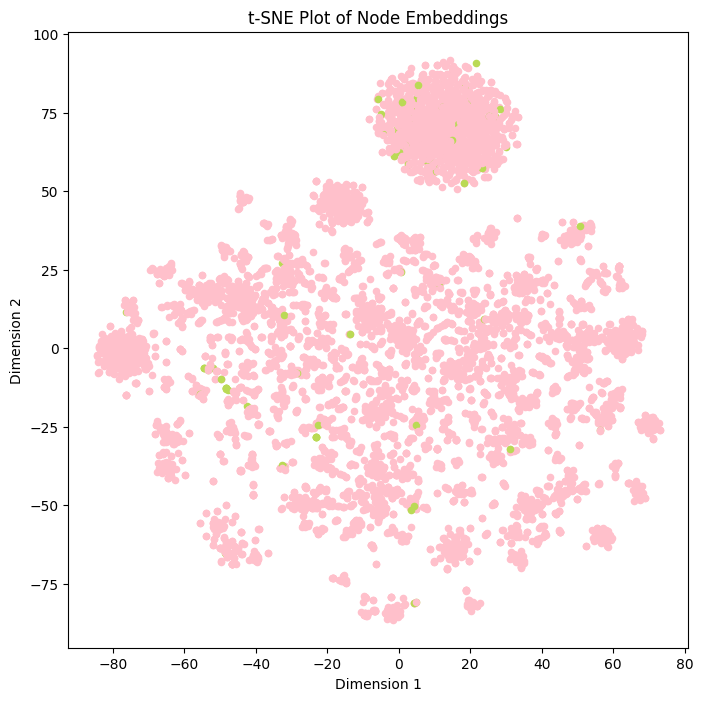

In [3]:
colors = [
    '#ffc0cb', '#bada55'
]

# Extract the embedding vectors
embedding_vectors = embedding_df_final.iloc[:, 1:-1].values
labels = embedding_df_final.iloc[:, -1].values

# Apply t-SNE to reduce the dimensionality to 2
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embedding_vectors)

colors = [
    '#ffc0cb', '#bada55'
]

# Create a scatter plot of the embeddings
plt.figure(figsize=(8, 8))
for df_index, protein_name in enumerate(embedding_df_final.iloc[:, 0].values):
    node_index = PPI_graph.vs.find(name=protein_name).index
    node_label = PPI_graph.vs[node_index]['label']
        
    if node_label == 0:
        plt.scatter(embeddings_2d[df_index, 0], embeddings_2d[df_index, 1], s=20, color=colors[0])
    elif node_label == 1:
        plt.scatter(embeddings_2d[df_index, 0], embeddings_2d[df_index, 1], s=20, color=colors[1])

plt.title('t-SNE Plot of Node Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig(r'C:\Users\George\Desktop\ISEF-2023\Model\test\node2vec_PPI\embedded_photo.png', dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
plt.show()


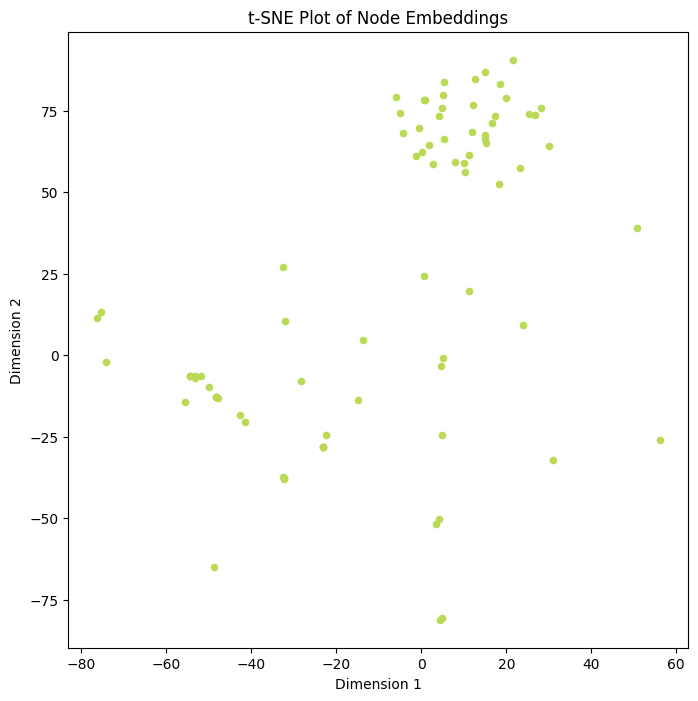

: 

In [4]:
plt.figure(figsize=(8, 8))
for df_index, protein_name in enumerate(embedding_df_final.iloc[:, 0].values):
    node_index = PPI_graph.vs.find(name=protein_name).index
    node_label = PPI_graph.vs[node_index]['label']
        
    if node_label == 0:
        #plt.scatter(embeddings_2d[df_index, 0], embeddings_2d[df_index, 1], s=20, color=colors[0])
        pass
    elif node_label == 1:
        plt.scatter(embeddings_2d[df_index, 0], embeddings_2d[df_index, 1], s=20, color=colors[1])

plt.title('t-SNE Plot of Node Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig(r'C:\Users\George\Desktop\ISEF-2023\Model\test\node2vec_PPI\embedded_photo.png', dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
plt.show()